In [138]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from __future__ import print_function

In [29]:
cd test_globetool

/home/clyde/Dropbox/Project Stuff/Notebooks/test_cases/test_globetool


In [13]:
%matplotlib inline

In [139]:
def to_globetoolbox(fn_base, times,wavelengths,spec):
    """Outputs data in a form that can be read by the Matlab Global Toolbox"""
    data = np.vstack([times,spec]).T
    np.savetxt(fn_base + '_spectrum.dat',data)
    np.savetxt(fn_base + '_calibration.dat',wavelengths)
    return data 

def svd_plot(main_d, main_t,main_w,n=4):
    U, s, V = np.linalg.svd(main_d.T, full_matrices=True)
    plt.figure(figsize=(12,8))

    for i in range(n):
        plt.subplot(2,n,i+1)
        plt.title('LSV {n_}\n singular value {s_:.2f}'.format(n_=i, s_=s[i]))
        plt.semilogx(main_t, U[:,i])
        plt.subplot(2,n,i+n+1)
        plt.plot(main_w, V[i,:])
    plt.show()
    return U,s,V

def svd_fit(t, U, V, wls, n_ks=3, p0=None):
    def h_exp(t, *args):
        """Function corresponding to a sum of an arbitrary number of exponentials of the form

        $\sum_{1}^{N} A_n e^{-k_n*t}$

        We use this function to fit transformed time series spectra where we wish to produce a single set of rate constants
        for several different traces yet allow the amplitudes to vary freely.

        To achieve this we combine the separate times/spectra into a single data set which is used to fit parameters using this function.
        The function is passed a vector of times values which is repeated for however many seperate traces we have.
        Within the function these values are transformed, the same k parameters are used for all traces while seperate amplitudes and coefficents are used.
        """

        #the seperate time series arrays one for each trace we are trying to predict

        T = t.reshape([n_comps,n_time_steps])
        #T = [t[n_time_steps*i:n_time_steps*(i+1)] for i in range(n_comps)]

        #amplitudes for each trace and each rate constant
        A = [np.array(args[n_ks*i:n_ks*(i+1)]) for i in range(n_comps)]
        #the OD offset coefficient
        C = args[n_comps*n_ks:n_comps*(n_ks+1)]
        #the single set of k values
        k = np.array(args[n_comps*(n_ks+1):])

        #print(k)
        #for each trace we sum exponentials defined by the k parameters amplitudes and coefficients
        temp_y = [np.sum(a[np.newaxis].T*np.e**(-k[np.newaxis].T*t),axis=0) + c for c,t,a in zip(C,T,A)]
        #print(temp_y)
        y = temp_y#[ty[0] for ty in temp_y]

        #we then return the correponding predicted traces stacked together
        return np.hstack(y)

    n_time_steps = len(t)
    n_comps = U.shape[1]

    stacked_times = np.hstack([t for i in range(n_comps)])
    #stacked_traces = np.hstack([U[:,i] for i in range(n_comps)]) 
    stacked_traces = U.T.reshape(n_comps * n_time_steps)
    
    guess_amps = [0.05 for i in range(n_comps * n_ks)]
    guess_coeffs = [0 for i in range(n_comps)]
    guess_ks = [1*10**-(i+1) for i in range(n_ks)]

    if p0 is None:
        p0=guess_amps + guess_coeffs + guess_ks

    p,conv = curve_fit(h_exp, stacked_times , stacked_traces, p0=p0)

    amps = p[:n_comps*n_ks].reshape(n_comps,n_ks)
    offset = p[n_comps*n_ks:n_comps*(n_ks+1)]
    ks = p[-n_ks:]

    amp_uncerts = np.array([(conv**0.5)[i,i] for i in range(conv.shape[0])])[:n_comps*n_ks].reshape(n_comps,n_ks)
    k_uncerts = [(conv**0.5)[i,i] for i in range(conv.shape[0])][-n_ks:]

    resids =  sum((h_exp(stacked_times,*p) - stacked_traces)**2)
    
    plt.figure(figsize=(16,4))

    for i in range(n_comps):
        plt.subplot(2,n_comps,i+1)
        plt.semilogx(t, U[:,i],label='lsv')
        plt.semilogx(t, h_exp(stacked_times,*p)[n_time_steps*i:n_time_steps*(i+1)],label='fit')

        if not i:
            plt.legend()

    for i in range(n_comps):
        plt.subplot(2,n_comps,n_comps + i+1)
        plt.plot(wls, V[i,:],label='rsv')

        if not i:
            plt.legend()

    fig = plt.figure(figsize=(16,4))

    plt.title('Parallel model: Amplitude per component')
    for j in range(n_ks):
        plt.errorbar(range(n_comps),amps[:,j], yerr=amp_uncerts[:,j],label='{t:.2f}'.format(t=1/ks[j]))
    plt.xlabel('SVD component number')
    plt.legend()

    plt.xticks(range(n_comps))
    ax = fig.gca()
    ax.grid(True)

    plt.show()
    
    #print('amps : ', *amps)
    #print('OD offset : ', *offset)
    print('ks   : ', *ks)
    #print('ts   : ',*1/ks)
    print('k_uncerts: ', *k_uncerts)
    print('residuals: ',resids)
    
    return p

In [60]:
k=0.5
A=100
t = np.linspace(0,10)
w =[450,650]

c_a = A*np.e**(-k*t)
c_b = A*(1-np.e**(-k*t))

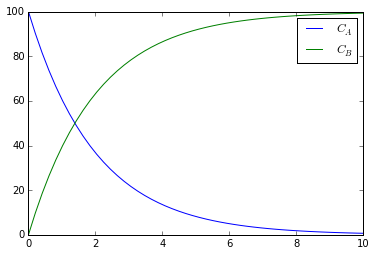

In [114]:
plt.plot(t,c_a, label='$C_A$')
plt.plot(t,c_b, label='$C_B$')
plt.legend()
plt.show()

In [156]:
a_400 = 0.9*c_a + 0.1*c_b + np.random.randn(len(t))
a_650 = 0.2*c_a + 0.8*c_b + np.random.randn(len(t))

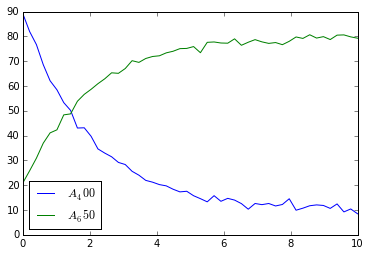

In [157]:
plt.plot(t,a_400, label='$A_400$')
plt.plot(t,a_650, label='$A_650$')
plt.legend(loc=3)
plt.show()

In [158]:
spec = np.array([a_400,a_650])
d = to_globetoolbox('test_spec', t,w,spec)

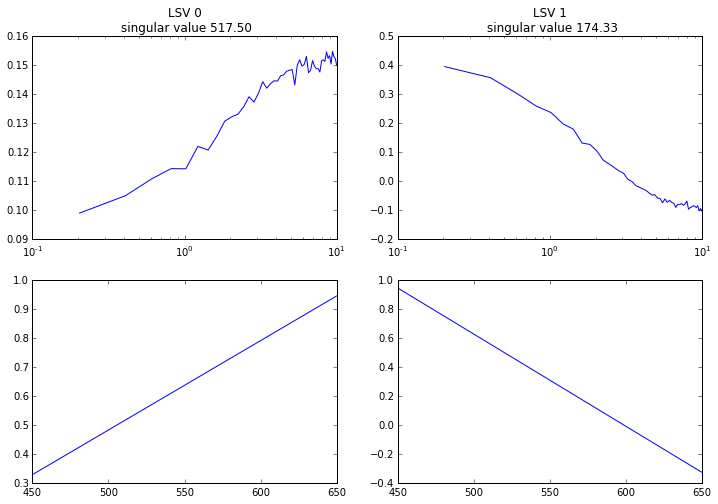

In [159]:
U,s,V=svd_plot(spec,t,w,n=2)

/home/clyde/anaconda/envs/dev/lib/python2.7/site-packages/IPython/kernel/__main__.py:76: RuntimeWarning: invalid value encountered in sqrt
/home/clyde/anaconda/envs/dev/lib/python2.7/site-packages/IPython/kernel/__main__.py:77: RuntimeWarning: invalid value encountered in sqrt


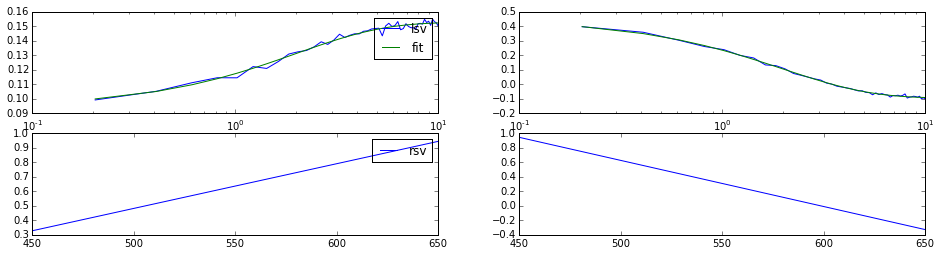

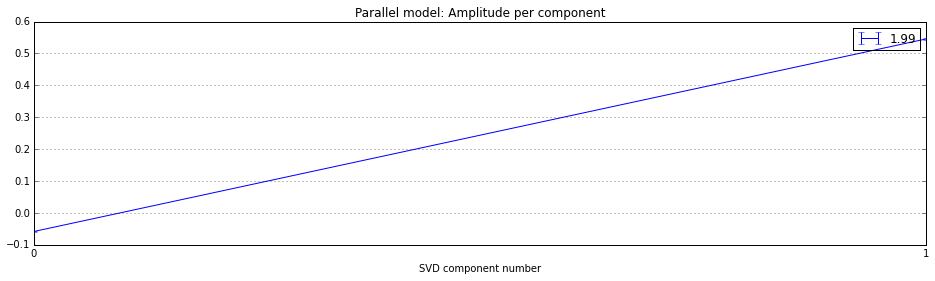

ks   :  0.502007602586
k_uncerts:  0.00550960361689
residuals:  0.00204803506546


array([-0.05850799,  0.54574626,  0.15255088, -0.09637154,  0.5020076 ])

In [160]:
svd_fit(t, U[:,:2], V[:2,:], w, n_ks=1)

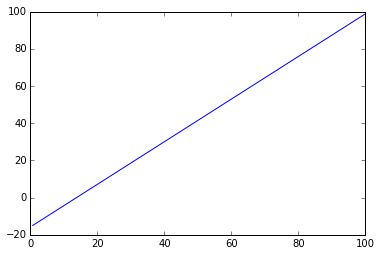

In [109]:
plt.plot(c_a,s[1]*U[:,1])

In [110]:
V

array([[ 0.15749481,  0.98751981],
       [ 0.98751981, -0.15749481]])